In [297]:
import os, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import random

In [298]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)
rng = np.random.default_rng(7)

# Config 

In [ ]:
@dataclass
class SimCfg:
    R: float = 200.0
    P_max: float = 200.0
    S_L: float = 1.0
    S_W: float = 0.75
    c_price: float = 0.1
    B: float = 10**6
    n0: float = None         
    Fs: int = 3                
    K: int = 3             
    N: int = 5

In [300]:
def pathloss_gain(d):
    return -(120.9 + 37.6 * np.log10(d / 1000.0)) + 7 * np.random.normal(1, size=d.shape)

In [301]:
def calculate_channel_matrix(distances, is_bs: bool):
    d = distances.reshape(-1, 1) if is_bs else distances
    pathloss = pathloss_gain(d)
    small_scale = np.random.normal(1, size=d.shape) ** 2
    channel_gain = 10 ** (pathloss / 10.0) * small_scale
    return np.abs(channel_gain).astype(np.float32)

In [302]:
class StandardScalerNP:
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = X.mean(0)
        self.std_ = X.std(0)
        self.std_[self.std_==0]=1.0
    def transform(self, X): return (X-self.mean_)/self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

# Generate dataset 

In [303]:
# # -------------------------------
# # Environment Setup
# # -------------------------------
# R = 200
# P_max = 200
# S_L = 1         # LTE satisfaction per unit rate
# S_W = 0.75      # WiFi satisfaction per unit rate



# c = 0.1         # Cost per unit data rate
# B = 10**6       # Bandwidth
# n0 = B * 10**-17.4  # Noise power

# F = 3          # Number of subchannels
# K = 3           # Number of WiFi APs
# N = 5           # Number of users

# bs_location = np.array([R, R])
# user_locations = []
# ap_locations = []
# C_i = []         # User affordability
# L_thr = []       # Satisfaction thresholds

# # Random affordability for 40% of users
# selected_users = set(random.sample(range(N), int(N * 0.4)))

# for i in range(N):
#     L_thr.append(0.3)
#     x, y = np.random.uniform(0, 2 * R, size=2)
#     user_locations.append([x, y])
#     C = np.random.uniform(5, 10) if i in selected_users else 0
#     C_i.append(C)

# for i in range(K):
#     x, y = np.random.uniform(0, 2 * R, size=2)
#     ap_locations.append([x, y])

# user_locations = np.array(user_locations)
# ap_locations = np.array(ap_locations)

# # -------------------------------
# # Channel Calculation
# # -------------------------------

# def calculate_channel_matrix(distances, is_bs):
#     if is_bs:
#         distances = distances.reshape(-1, 1)
#     pathloss = -(120.9 + 37.6 * np.log10(distances / 1000)) + \
#                7 * np.random.normal(1, size=distances.shape)
#     small_scale = np.random.normal(1, size=distances.shape)**2
#     channel_gain = 10 ** (pathloss / 10) * small_scale
#     return np.abs(channel_gain)

# d_user_ap = np.linalg.norm(user_locations[:, None] - ap_locations, axis=2)
# d_user_bs = np.linalg.norm(user_locations - bs_location, axis=1)
# h_ik = calculate_channel_matrix(d_user_ap, is_bs=False)
# h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).flatten()

# # -------------------------------
# # Random Fixed Assignments: X, Ψ, q
# # -------------------------------

# X_iL = np.zeros(N)
# X_ik = np.zeros((N, K))
# Psi = np.zeros((N, F))
# q = np.random.randint(0, 2, N)  # Random satisfaction indicator

# for i in range(N):
#     sel = np.random.choice(K + 1)
#     if sel == K:
#         X_iL[i] = 1
#     else:
#         X_ik[i, sel] = 1
#     Psi[i, np.random.choice(F)] = 1

In [ ]:
def generate_dataset(cfg: SimCfg, seed: int = 7, standardize: bool = True):
    random.seed(seed)
    n0 = cfg.B * 10**-17.4 if (cfg.n0 is None) else cfg.n0
    bs_location = np.array([cfg.R, cfg.R], dtype=np.float32)

    user_locations, ap_locations = [], []
    C_i, L_thr = [], []

    # Random affordability for 40% of users
    selected_users = set(random.sample(range(cfg.N), max(1, int(cfg.N * 0.4))))

    for i in range(cfg.N):
        L_thr.append(0.3)
        x, y = np.random.uniform(0, 2 * cfg.R, size=2)
        user_locations.append([x, y])
        C = np.random.uniform(5, 10) if i in selected_users else 0.0
        C_i.append(C)

    for i in range(cfg.K):
        x, y = np.random.uniform(0, 2 * cfg.R, size=2)
        ap_locations.append([x, y])

    user_locations = np.array(user_locations, dtype=np.float32)
    ap_locations   = np.array(ap_locations,   dtype=np.float32)
    C_i  = np.array(C_i,  dtype=np.float32)
    L_thr= np.array(L_thr,dtype=np.float32)

    # -------------------------------
    # Channel Calculation
    # -------------------------------

    d_user_ap = np.linalg.norm(user_locations[:, None] - ap_locations[None, :], axis=2)  # (N,K)
    d_user_bs = np.linalg.norm(user_locations - bs_location, axis=1)                     # (N,)
    h_ik = calculate_channel_matrix(d_user_ap, is_bs=False)                               # (N,K)
    h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).flatten()                      # (N,)

    # -------------------------------
    # Random Fixed Assignments: X, Ψ, q
    # -------------------------------
    X_iL = np.zeros(cfg.N, dtype=np.int64)
    X_ik = np.zeros((cfg.N, cfg.K), dtype=np.int64)
    Psi  = np.zeros((cfg.N, cfg.Fs), dtype=np.int64)
    q    = np.random.randint(0, 2, cfg.N).astype(np.int64)  # Random satisfaction indicator

    subband_idx = np.zeros(cfg.N, dtype=np.int64)
    ap_idx      = -np.ones(cfg.N, dtype=np.int64)  # -1 nếu LTE

    for i in range(cfg.N):
        sel = np.random.choice(cfg.K + 1)  # {0..K-1}=AP, K=LTE
        if sel == cfg.K:
            X_iL[i] = 1
            ap_idx[i] = -1
        else:
            X_ik[i, sel] = 1
            ap_idx[i] = sel
        f = np.random.choice(cfg.Fs)
        Psi[i, f] = 1
        subband_idx[i] = f

    # -------------------------------
    # Interference matrix Hbar
    Hbar = np.zeros((cfg.N, cfg.N), dtype=np.float32)
    for i in range(cfg.N):
        if X_iL[i] == 1:
            Hbar[i, :] = h_iL[:]
        else:
            kstar = ap_idx[i]
            Hbar[i, :] = h_ik[:, kstar]
    np.fill_diagonal(Hbar, 0.0)

    # -------------------------------
    # Build graph edges
    # -------------------------------
    P_vec = np.full(cfg.N, cfg.P_max, dtype=np.float32)  # nếu muốn power cá nhân, thay ở đây
    edge_src, edge_dst, edge_w = [], [], []
    for f in range(cfg.Fs):
        ids = np.where(subband_idx == f)[0]
        if ids.size <= 1:
            continue
        for a in ids:
            for b in ids:
                if a == b: 
                    continue
                w = P_vec[b] * Hbar[a, b]
                edge_src.append(a); edge_dst.append(b); edge_w.append(float(w))

    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
    edge_weight = torch.tensor(edge_w, dtype=torch.float32)


    feat_cols = ["Pmax", "Ci", "Lthr", "h_iL"] + [f"h_i{k}" for k in range(cfg.K)]
    df = pd.DataFrame({
        "Pmax": np.full(cfg.N, cfg.P_max, dtype=np.float32),
        "Ci":   C_i,
        "Lthr": L_thr,
        "h_iL": h_iL
    })
    for k in range(cfg.K):
        df[f"h_i{k}"] = h_ik[:, k]
    df["subband"] = subband_idx
    df["x_LTE"]   = X_iL
    df["ap_idx"]  = ap_idx
    df["q"]       = q

    X_np = df[feat_cols].to_numpy(np.float32)
    if standardize:
        X_mean = X_np.mean(axis=0); X_std = X_np.std(axis=0); X_std[X_std == 0] = 1.0
        X_np = (X_np - X_mean) / X_std

    data = Data(
        x=torch.tensor(X_np, dtype=torch.float32),
        edge_index=edge_index,
        edge_weight=edge_weight
    )

    aux = {
        "g_iL": torch.tensor(h_iL, dtype=torch.float32),
        "g_ik": torch.tensor(h_ik, dtype=torch.float32),
        "Pmax": torch.tensor(np.full(cfg.N, cfg.P_max, dtype=np.float32), dtype=torch.float32),
        "Ci":   torch.tensor(C_i, dtype=torch.float32),
        "Lthr": torch.tensor(L_thr, dtype=torch.float32),
        "noise": torch.tensor(float(n0), dtype=torch.float32),
        "SL": torch.tensor(float(cfg.S_L), dtype=torch.float32),
        "SW": torch.tensor(float(cfg.S_W), dtype=torch.float32),
        "cprice": torch.tensor(float(cfg.c_price), dtype=torch.float32),
        "N": cfg.N, "K": cfg.K, "F": cfg.Fs,
        "X_iL": torch.tensor(X_iL, dtype=torch.int64),
        "X_ik": torch.tensor(X_ik, dtype=torch.int64),
        "Psi":  torch.tensor(Psi,  dtype=torch.int64),
        "q":    torch.tensor(q,    dtype=torch.int64),
        "subband_idx": torch.tensor(subband_idx, dtype=torch.int64),
        "ap_idx":      torch.tensor(ap_idx,      dtype=torch.int64),
        "user_xy": torch.tensor(user_locations, dtype=torch.float32),
        "ap_xy":   torch.tensor(ap_locations,   dtype=torch.float32),
        "bs_xy":   torch.tensor([cfg.R, cfg.R], dtype=torch.float32)
    }

    return df, data, aux


In [305]:
cfg = SimCfg()
df, data, aux = generate_dataset(cfg, seed=7)

# Policy-GCN

In [ ]:
class PolicyGCN(nn.Module):
    def __init__(self, in_dim, hidden, K, Fs):
        super().__init__()
        #embedding
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        # outputs:
        self.recv_head = nn.Linear(hidden, K+1)  # [LTE | AP1..APK]
        self.band_head = nn.Linear(hidden, Fs)    # subband logits
        self.pow_head  = nn.Linear(hidden, 1)    # power logit -> sigmoid

    def forward(self, x, edge_index, edge_weight=None):
        h = self.conv1(x, edge_index, edge_weight=edge_weight)
        h = F.relu(h)
        h = self.conv2(h, edge_index, edge_weight=edge_weight)
        h = F.relu(h)
        recv_logits = self.recv_head(h)          # (N, K+1)
        band_logits = self.band_head(h)          # (N, F)
        pow_logit   = self.pow_head(h).squeeze(-1)  # (N,)
        w_rx = F.softmax(recv_logits, dim=-1)    # (N, K+1)
        p_f  = F.softmax(band_logits, dim=-1)    # (N, F)
        a    = torch.sigmoid(pow_logit)          # (N,)
        return w_rx, p_f, a

In [ ]:
model = PolicyGCN(in_dim=data.x.size(-1), hidden=256, K=cfg.K, Fs=cfg.Fs).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-3)

# Differentiable objective: maximize total satisfaction

In [308]:
def objective_total_satisfaction(w_rx, p_f, a, aux):
    """
    w_rx: (N, K+1)  -> wL = [:,0], wW = [:,1:]
    p_f:  (N, F)    -> per-user subband soft assignment
    a:    (N,)      -> power fraction in [0,1]
    Returns: (mean_L, penalties_dict)
    """
    g_iL = aux["g_iL"]    # (N,)
    g_ik = aux["g_ik"]    # (N,K)
    Pmax = aux["Pmax"]    # (N,)
    Ci   = aux["Ci"]      # (N,)
    Lthr = aux["Lthr"]    # (N,)
    noise = aux["noise"]  # scalar
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]
    N, K, Fs = aux["N"], g_ik.size(1), p_f.size(1)

    wL = w_rx[:, 0]         # (N,)
    wW = w_rx[:, 1:]        # (N,K)

    # desired gain for user i: h_des[i]
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                # (N,)

    # interference matrix Hbar_soft: H[i,j] = wL[i]*g_L[j] + sum_k wW[i,k]*g_ik[j,k]
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)               # (N,N)
    term2 = wW @ g_ik.transpose(0,1)                          # (N,N)
    Hbar = term1 + term2
    Hbar.fill_diagonal_(0.0)

    # transmit power
    P = a * Pmax                                              # (N,)

    # SINR_i = sum_f p_if * (P_i*h_des[i]) / (sum_j p_jf * P_j * Hbar[i,j] + noise)
    num = P * h_des                                           # (N,)
    SINR = torch.zeros_like(num)
    for f in range(Fs):
        S_f = p_f[:, f] * P                                   # (N,)
        denom = Hbar @ S_f + noise                            # (N,)
        SINR = SINR + p_f[:, f] * (num / (denom + 1e-30))
    rate = torch.log2(1.0 + SINR)                             # (N,)

    # Satisfaction
    S_i = SW + (SL - SW) * wL                                 # (N,)
    L_i = S_i * rate                                          # (N,)

    mean_L = L_i.mean()

    # Penalties:
    # Budget (LTE): c * r_i * wL <= Ci  -> relu(c*r_i*wL - Ci)
    budget_violation = F.relu(cprice * rate * wL - Ci).mean()

    # QoS: L_i >= Lthr  -> relu(Lthr - L_i)
    qos_violation = F.relu(Lthr - L_i).mean()

    penalties = {
        "budget": budget_violation,
        "qos": qos_violation
    }
    return mean_L, penalties

In [ ]:
EPOCHS = 1000
lambda_budget = 10.0
lambda_qos    = 10.0

logs = []
for ep in range(1, EPOCHS+1):
    model.train(); opt.zero_grad()
    w_rx, p_f, a = model(data.x, data.edge_index, data.edge_weight)
    mean_L, pens = objective_total_satisfaction(w_rx, p_f, a, aux)
    loss = -mean_L + lambda_budget * pens["budget"] + lambda_qos * pens["qos"]
    loss.backward()
    opt.step()

    if ep % 100 == 0 or ep == 1:
        with torch.no_grad():
            # report a few interpretable scalars
            avg_wL = w_rx[:,0].mean().item()
            avg_power = (a*aux["Pmax"]).mean().item()
            print(f"Ep {ep:03d} | Loss {loss.item():.6f} | meanL {mean_L.item():.4f} "
                  f"| budget {pens['budget'].item():.4f} | qos {pens['qos'].item():.4f} "
                  f"| <wLTE> {avg_wL:.3f} | <P> {avg_power*1e3:.2f} mW")
    logs.append({
        "epoch": ep,
        "loss": float(loss.item()),
        "meanL": float(mean_L.item()),
        "budget": float(pens["budget"].item()),
        "qos": float(pens["qos"].item())
    })


Ep 001 | Loss 0.596714 | meanL 0.7146 | budget 0.0204 | qos 0.1107 | <wLTE> 0.248 | <P> 98627.14 mW
Ep 100 | Loss -9.362868 | meanL 9.4275 | budget 0.0065 | qos 0.0000 | <wLTE> 0.400 | <P> 121322.78 mW
Ep 200 | Loss -9.377335 | meanL 9.4611 | budget 0.0066 | qos 0.0018 | <wLTE> 0.400 | <P> 119108.66 mW
Ep 300 | Loss -9.348630 | meanL 9.4365 | budget 0.0088 | qos 0.0000 | <wLTE> 0.400 | <P> 120438.09 mW
Ep 400 | Loss -9.373893 | meanL 9.4504 | budget 0.0058 | qos 0.0018 | <wLTE> 0.400 | <P> 120116.59 mW
Ep 500 | Loss -9.384996 | meanL 9.4524 | budget 0.0067 | qos 0.0000 | <wLTE> 0.400 | <P> 120832.11 mW
Ep 600 | Loss -9.387357 | meanL 9.4590 | budget 0.0064 | qos 0.0008 | <wLTE> 0.400 | <P> 120840.23 mW
Ep 700 | Loss -9.355628 | meanL 9.4385 | budget 0.0057 | qos 0.0025 | <wLTE> 0.400 | <P> 121654.15 mW
Ep 800 | Loss -9.374082 | meanL 9.4505 | budget 0.0058 | qos 0.0018 | <wLTE> 0.400 | <P> 121719.91 mW
Ep 900 | Loss -9.391794 | meanL 9.4541 | budget 0.0062 | qos 0.0000 | <wLTE> 0.400 |

# Evaluate performance 

In [310]:
@torch.no_grad()
def evaluate_policy_snapshot(policy, data, aux):
    policy.eval()
    w_rx, p_f, a = policy(data.x, data.edge_index, data.edge_weight)

    # Unpack
    g_iL = aux["g_iL"]      # (N,)
    g_ik = aux["g_ik"]      # (N,K)
    Pmax = aux["Pmax"]      # (N,)
    Ci   = aux["Ci"]        # (N,)
    Lthr = aux["Lthr"]      # (N,)
    noise = aux["noise"]    # scalar
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]

    N = g_iL.size(0)
    wL = w_rx[:, 0]
    wW = w_rx[:, 1:]                         # (N,K)

    # Desired gain & interference matrix
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                  # (N,)
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)                 # (N,N)
    term2 = wW @ g_ik.transpose(0,1)                            # (N,N)
    Hbar  = term1 + term2
    Hbar.fill_diagonal_(0.0)

    # Power, SINR, rate
    P = a * Pmax                                                # (N,)
    num = P * h_des
    SINR = torch.zeros_like(num)
    Fbands = p_f.size(1)
    for f in range(Fbands):
        S_f = p_f[:, f] * P                                     # (N,)
        denom = Hbar @ S_f + noise
        SINR += p_f[:, f] * (num / (denom + 1e-30))
    rate = torch.log2(1.0 + SINR)

    # Satisfaction & constraints
    S_i = SW + (SL - SW) * wL
    L_i = S_i * rate
    budget_violation = torch.relu(cprice * rate * wL - Ci)      # per-user
    qos_violation    = torch.relu(Lthr - L_i)                   # per-user

    # Aggregate stats
    stats = {
        "mean_L": float(L_i.mean().item()),
        "mean_rate": float(rate.mean().item()),
        "mean_wLTE": float(wL.mean().item()),
        "mean_P": float((P).mean().item()),
        "budget_violation_mean": float(budget_violation.mean().item()),
        "qos_violation_mean": float(qos_violation.mean().item()),
    }
    per_user = {
        "wL": wL.detach().cpu().numpy(),
        "P": P.detach().cpu().numpy(),
        "rate": rate.detach().cpu().numpy(),
        "L": L_i.detach().cpu().numpy(),
        "budget_violation": budget_violation.detach().cpu().numpy(),
        "qos_violation": qos_violation.detach().cpu().numpy(),
        "subband_load": p_f.detach().cpu().numpy().sum(axis=0),  # (F,)
    }
    return stats, per_user


## Convergence

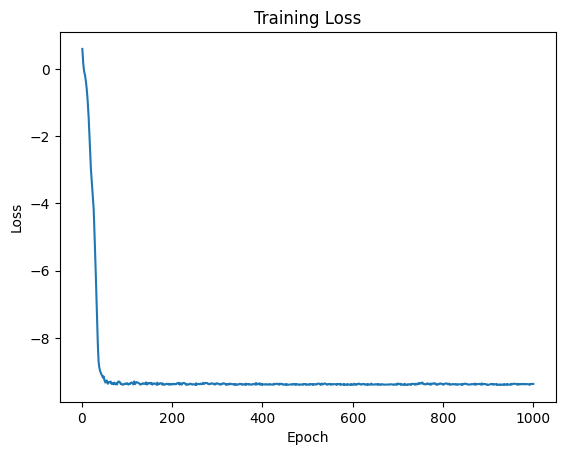

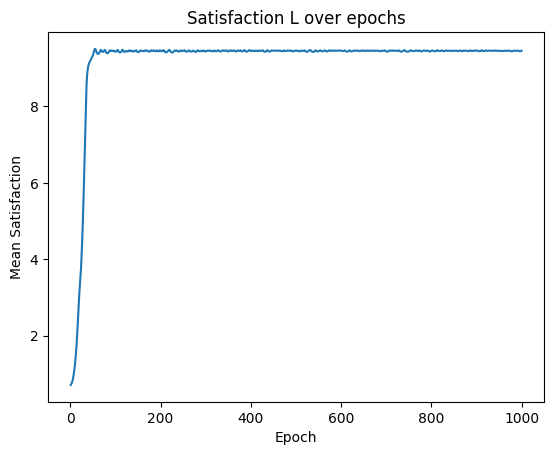

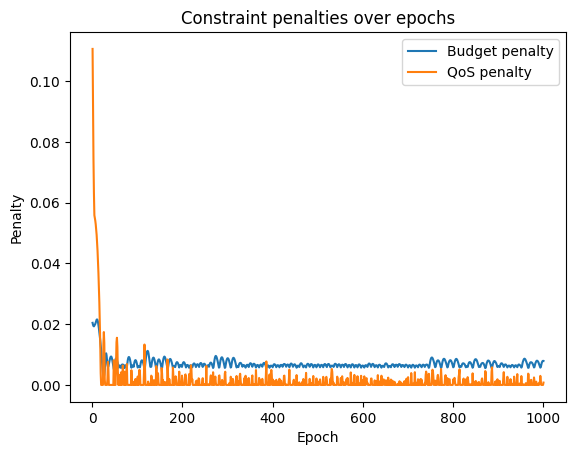

In [311]:
import matplotlib.pyplot as plt

df_logs = pd.DataFrame(logs)
# Training Convergence
plt.figure()
plt.plot(df_logs["epoch"], df_logs["loss"])
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

#Satisfaction
plt.figure()
plt.plot(df_logs["epoch"], df_logs["meanL"])
plt.xlabel("Epoch"); plt.ylabel("Mean Satisfaction")
plt.title("Satisfaction L over epochs")
plt.show()

#Penalty
plt.figure()
plt.plot(df_logs["epoch"], df_logs["budget"], label="Budget penalty")
plt.plot(df_logs["epoch"], df_logs["qos"], label="QoS penalty")
plt.xlabel("Epoch"); plt.ylabel("Penalty")
plt.title("Constraint penalties over epochs")
plt.legend()
plt.show()


In [ ]:
stats, per_user = evaluate_policy_snapshot(model, data, aux)
print("Snapshot stats:", stats)

Snapshot stats: {'mean_L': 9.457064628601074, 'mean_rate': 12.563952445983887, 'mean_wLTE': 0.39999672770500183, 'mean_P': 122.59452819824219, 'budget_violation_mean': 0.0077759874984622, 'qos_violation_mean': 0.00135794875677675}


## Distribution selection

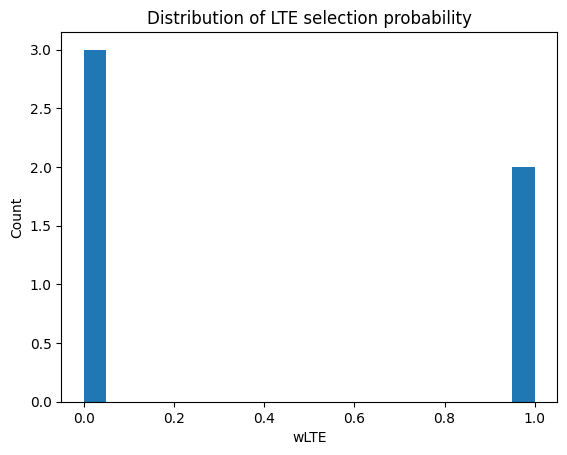

In [313]:
plt.figure()
plt.hist(per_user["wL"], bins=20)
plt.xlabel("wLTE")
plt.ylabel("Count")
plt.title("Distribution of LTE selection probability")
plt.show()


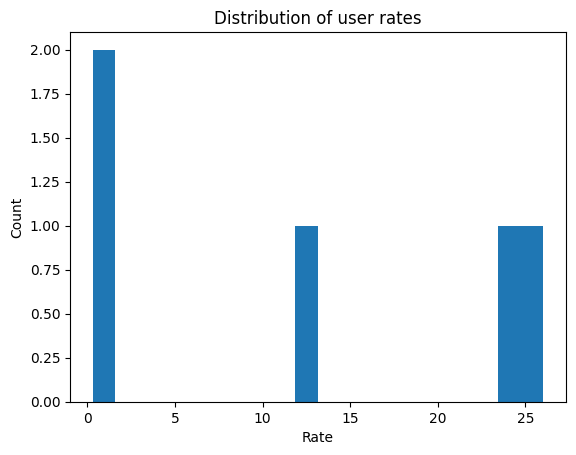

In [314]:
plt.figure()
plt.hist(per_user["rate"], bins=20)
plt.xlabel("Rate")
plt.ylabel("Count")
plt.title("Distribution of user rates")
plt.show()


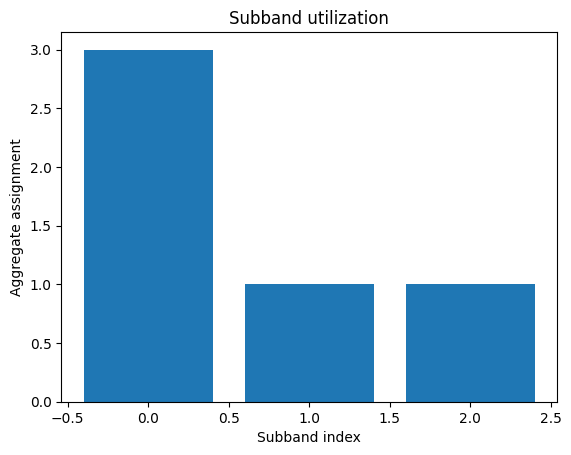

In [315]:
subband_load = per_user["subband_load"]  # shape (F,)
plt.figure()
plt.bar(range(len(subband_load)), subband_load)
plt.xlabel("Subband index")
plt.ylabel("Aggregate assignment")
plt.title("Subband utilization")
plt.show()


## Constraint validation

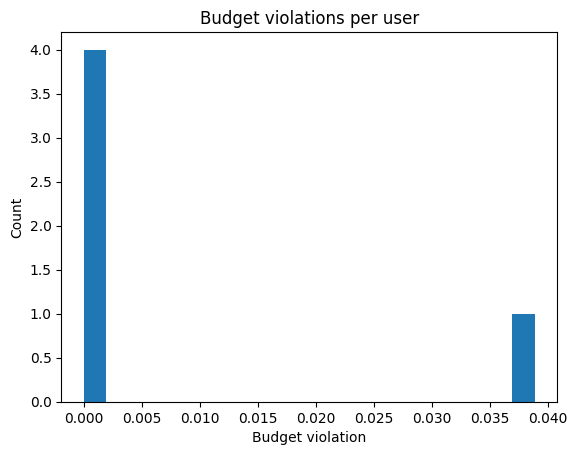

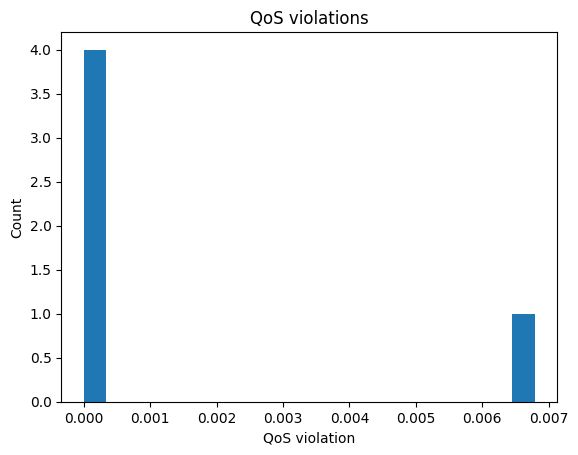

In [316]:
#Budget Ci
plt.figure()
plt.hist(per_user["budget_violation"], bins=20)
plt.xlabel("Budget violation")
plt.ylabel("Count")
plt.title("Budget violations per user")
plt.show()

# QoS
plt.figure()
plt.hist(per_user["qos_violation"], bins=20)
plt.xlabel("QoS violation")
plt.ylabel("Count")
plt.title("QoS violations")
plt.show()
